```
Author: Ehsan Kamalinejad (EK)
Created: 2023-02-25
```

# PPO Training

This notebook is a basic implementation of reinforcement learning (RL) training through proximal policy optimization (PPO). PPO is the default RL training for many problems at OpenAI and has great performance while very flexible. Here, the focus is education and simplicity.

Here, we will learn how to train a RL agent from scratch through PPO. This will be useful when we do (reinforcement learning with human feedback) RLHF to fine-tune language models in future lectures.

Pre-requisites:
- Intermediate level familiarity with Python and PyTorch.
- Intermediate level familiarity with general concepts in machine learning (ML) and gradient based optimization.
- Basic familiarity with concepts in RL such as environments, rewards, agents, etc.

Dependencies:
```
pip install torch --extra-index-url https://download.pytorch.org/whl/cu116
pip install moviepy omegaconf matplotlib
pip install gym==0.26.2
pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests
pip install gym[classic_control] gym[atari] gym[accept-rom-license] gym[other]
```

References:
- [EK's Video Lecture](https://www.youtube.com/watch?v=3uvnoVjM8nY) This is the lecture where we did a deep dive into the theory of PPO.
- [OpenAI PPO Repo](https://github.com/openai/baselines/blob/master/baselines/ppo2/runner.py) This is helpful as a reference for further implementations.
- [PPO Paper](https://arxiv.org/abs/1707.06347) This is the original paper that introduced PPO.
- [Sergey Levine UC Berkley CS285](http://rail.eecs.berkeley.edu/deeprlcourse/) This is a complete course in RL.
- [Pieter Abbeel mini-course](https://www.youtube.com/watch?v=2GwBez0D20A&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0) This is a mini-course focusing on TRPO, PPO, DDPG and model free RL.
- [OpenAI Documentation on RL](https://spinningup.openai.com/en/latest/index.html) THis is OpenAI documentation on RL and parts of our code was borrowed from here.
- [labml.ai](https://nn.labml.ai/) This repo contains popular papers with their annotated PyTorch implementations.
- [cleanrl](https://github.com/vwxyzjn/cleanrl) This repo has clean implementations of RL algorithms and parts of our code was borrowed from here.

In [ ]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu116
!pip install moviepy omegaconf matplotlib
!pip install gym==0.26.2
!pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests
!pip install gym[classic_control] gym[atari] gym[accept-rom-license] gym[other]

In [ ]:
import time
import random
import numpy as np
import matplotlib.pylab as plt
plt.style.use('dark_background')
from tqdm.notebook import tqdm
from omegaconf import DictConfig

import gym

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.categorical import Categorical

from IPython.display import Video

## Setup

In [ ]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
configs = {
    # experiment arguments
    "exp_name": "cartpole",
    "gym_id": "CartPole-v1", # the id of from OpenAI gym
    # training arguments
    "learning_rate": 1e-3, # the learning rate of the optimizer
    "total_timesteps": 1000000, # total timesteps of the training
    "max_grad_norm": 0.5, # the maximum norm allowed for the gradient
    # PPO parameters
    "num_trajcts": 32, # N
    "max_trajects_length": 64, # T
    "gamma": 0.99, # gamma
    "gae_lambda":0.95, # lambda for the generalized advantage estimation
    "num_minibatches": 2, # number of mibibatches used in each gradient
    "update_epochs": 2, # number of full rollout storage creations
    "clip_epsilon": 0.2, # the surrogate clipping coefficient
    "ent_coef": 0.01, # entroy coefficient controlling the exploration factor C2
    "vf_coef": 0.5, # value function controlling value estimation importance C1
    # visualization and print parameters
    "num_returns_to_average": 3, # how many episodes to use for printing average return
    "num_episodes_to_average": 23, # how many episodes to use for smoothing of the return diagram
    }

# batch_size is the size of the flatten sequences when trajcts are flatten
configs['batch_size'] = int(configs['num_trajcts'] * configs['max_trajects_length'])
# number of samples used in each gradient
configs['minibatch_size'] = int(configs['batch_size'] // configs['num_minibatches'])

configs = DictConfig(configs)

run_name = f"{configs.gym_id}__{configs.exp_name}__{seed}__{int(time.time())}"

## Env

`envs` is a set of parallel environments each holding a random initiali `state` and accepts an `action` to change and return its new state.

In [ ]:
# create an env with random state
def make_env_func(gym_id, seed, idx, run_name, capture_video=False):
    def env_fun():
        env = gym.make(gym_id, render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            # initiate the video capture if not already initiated
            if idx == 0:
                # wrapper to create the video of the performance
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return env_fun

In [ ]:
# create N envs
envs = []
for i in range(configs.num_trajcts):
    envs.append( make_env_func(configs.gym_id, seed + i, i, run_name) )
envs = gym.vector.SyncVectorEnv(envs)
envs

SyncVectorEnv(32)

## Model

A simple fully connected model that gets a state and has two methods:
- `agent.value_func(state)` gets a state and returns the estimated expected total future rewards from that state $V_{\theta}(s)$.
- `agent.policy(state)` gets a state and returns next `action`, `log_prob` of actions, the `entropy` and `value`.

In [ ]:
class FCBlock(nn.Module):
    """A generic fully connected residual block with good setup"""
    def __init__(self, embd_dim, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(embd_dim),
            nn.GELU(),
            nn.Linear(embd_dim, 4*embd_dim),
            nn.GELU(),
            nn.Linear(4*embd_dim, embd_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return x + self.block(x)


class Agent(nn.Module):
    """an agent that creates actions and estimates values"""
    def __init__(self, env_observation_dim, action_space_dim, embd_dim=64, num_blocks=2):
        super().__init__()
        self.embedding_layer = nn.Linear(env_observation_dim, embd_dim)
        self.shared_layers = nn.Sequential(*[FCBlock(embd_dim=embd_dim) for _ in range(num_blocks)])
        self.value_head = nn.Linear(embd_dim, 1)
        self.policy_head = nn.Linear(embd_dim, action_space_dim)
        # orthogonal initialization with a hi entropy for more exploration at the start
        torch.nn.init.orthogonal_(self.policy_head.weight, 0.01)

    def value_func(self, state):
        hidden = self.shared_layers(self.embedding_layer(state))
        value = self.value_head(hidden)
        return value

    def policy(self, state, action=None):
        hidden = self.shared_layers(self.embedding_layer(state))
        logits = self.policy_head(hidden)
        # PyTorch categorical class helpful for sampling and probability calculations
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.value_head(hidden)

### Generalized Advantage Estimation

In [ ]:
def gae(
    cur_observation,  # the current state when advantages will be calculated
    rewards,          # rewards collected from trajectories of shape [num_trajcts, max_trajects_length]
    dones,            # binary marker of end of trajectories of shape [num_trajcts, max_trajects_length]
    values            # value estimates collected over trajectories of shape [num_trajcts, max_trajects_length]
):
    """
    Generalized Advantage Estimation (gae) estimating advantage of a particular trajecotry
    vs the expected return starting from a state
    """
    advantages = torch.zeros((configs.num_trajcts, configs.max_trajects_length))
    last_advantage = 0

    # the value after the last step
    with torch.no_grad():
        last_value = agent.value_func(cur_observation).reshape(1, -1)

    # reverse recursive to calculate advantages based on the delta formula
    for t in reversed(range(configs.max_trajects_length)):
        # mask if episode completed after step t
        mask = 1.0 - dones[:, t]
        last_value = last_value * mask
        last_advantage = last_advantage * mask
        delta = rewards[:, t] + configs.gamma * last_value - values[:, t]
        last_advantage = delta + configs.gamma * configs.gae_lambda * last_advantage
        advantages[:, t] = last_advantage
        last_value = values[:, t]

    advantages = advantages.to(device)
    returns = advantages + values

    return advantages, returns

### Creating Rollout Storage

In [ ]:
def create_rollout(
    envs,            # parallel envs creating trajectories
    cur_observation, # starting observation of shape [num_trajcts, observation_dim]
    cur_done,        # current termination status of shape [num_trajcts,]
    all_returns      # a list to track returns
):
    """
    rollout phase: create parallel trajectories and store them in the rollout storage
    """

    # cache empty tensors to store the rollouts
    observations = torch.zeros((configs.num_trajcts, configs.max_trajects_length) +
                               envs.single_observation_space.shape).to(device)
    actions = torch.zeros((configs.num_trajcts, configs.max_trajects_length) +
                          envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((configs.num_trajcts, configs.max_trajects_length)).to(device)
    rewards = torch.zeros((configs.num_trajcts, configs.max_trajects_length)).to(device)
    dones = torch.zeros((configs.num_trajcts, configs.max_trajects_length)).to(device)
    values = torch.zeros((configs.num_trajcts, configs.max_trajects_length)).to(device)

    for t in range(configs.max_trajects_length):
        observations[:,t] = cur_observation
        dones[:,t] = cur_done

        # give observation to the model and collect action, logprobs of actions, entropy and value
        with torch.no_grad():
            action, logprob, entropy, value = agent.policy(cur_observation)
        values[:,t] = value.flatten()
        actions[:,t] = action
        logprobs[:,t] = logprob

        # apply the action to the env and collect observation and reward
        cur_observation, reward, cur_done, _, info = envs.step(action.cpu().numpy())
        rewards[:,t] = torch.tensor(reward).to(device).view(-1)
        cur_observation = torch.Tensor(cur_observation).to(device)
        cur_done = torch.Tensor(cur_done).to(device)

        # if an episode ended store its total reward for progress report
        if info:
            for item in info['final_info']:
                if item and "episode" in item.keys():
                    all_returns.append(item['episode']['r'])
                    break

    # create the rollout storage
    rollout = {
        'cur_observation': cur_observation,
        'cur_done': cur_done,
        'observations': observations,
        'actions': actions,
        'logprobs': logprobs,
        'values': values,
        'dones': dones,
        'rewards': rewards
    }

    return rollout

In [ ]:
class Storage(Dataset):
    def __init__(self, rollout, advantages, returns, envs):
        # fill in the storage and flatten the parallel trajectories
        self.observations = rollout['observations'].reshape((-1,) + envs.single_observation_space.shape)
        self.logprobs = rollout['logprobs'].reshape(-1)
        self.actions = rollout['actions'].reshape((-1,) + envs.single_action_space.shape).long()
        self.advantages = advantages.reshape(-1)
        self.returns = returns.reshape(-1)

    def __getitem__(self, ix: int):
        item = [
            self.observations[ix],
            self.logprobs[ix],
            self.actions[ix],
            self.advantages[ix],
            self.returns[ix]
        ]
        return item

    def __len__(self) -> int:
        return len(self.observations)

### Loss Functions

In [ ]:
def loss_clip(
    mb_oldlogporb,     # old logprob of mini batch actions collected during the rollout
    mb_newlogprob,     # new logprob of mini batch actions created by the new policy
    mb_advantages      # mini batch of advantages collected during the the rollout
):
    """
    policy loss with clipping to control gradients
    """
    ratio = torch.exp(mb_newlogprob - mb_oldlogporb)
    policy_loss = -mb_advantages * ratio
    # clipped policy gradient loss enforces closeness
    clipped_loss = -mb_advantages * torch.clamp(ratio, 1 - configs.clip_epsilon, 1 + configs.clip_epsilon)
    pessimistic_loss = torch.max(policy_loss, clipped_loss).mean()
    return pessimistic_loss


def loss_vf(
    mb_oldreturns,  # mini batch of old returns collected during the rollout
    mb_newvalues    # minibach of values calculated by the new value function
):
    """
    enforcing the value function to give more accurate estimates of returns
    """
    mb_newvalues = mb_newvalues.view(-1)
    loss = 0.5 * ((mb_newvalues - mb_oldreturns) ** 2).mean()
    return loss

## Training

In [ ]:
agent = Agent(
    env_observation_dim=envs.single_observation_space.shape[0],
    action_space_dim=envs.single_action_space.n
).to(device)

optimizer = optim.Adam(agent.parameters(), lr=configs.learning_rate)

In [ ]:
# track returns
all_returns = []

# initialize the game
cur_observation = torch.Tensor(envs.reset()[0]).to(device)
cur_done = torch.zeros(configs.num_trajcts).to(device)

# progress bar
num_updates = configs.total_timesteps // configs.batch_size
progress_bar = tqdm(total=num_updates)

for update in range(1, num_updates + 1):


    ##############################################
    # Phase 1: rollout creation

    # parallel envs creating trajectories
    rollout = create_rollout(envs, cur_observation, cur_done, all_returns)

    cur_done = rollout['cur_done']
    cur_observation = rollout['cur_observation']
    rewards = rollout['rewards']
    dones = rollout['dones']
    values = rollout['values']

    # calculating advantages
    advantages, returns = gae(cur_observation, rewards, dones, values)

    # a dataset containing the rollouts
    dataset = Storage(rollout, advantages, returns, envs)

    # a standard dataloader made out of current storage
    trainloader = DataLoader(dataset, batch_size=configs.minibatch_size, shuffle=True)


    ##############################################
    # Phase 2: model update

    # linearly shrink the lr from the initial lr to zero
    frac = 1.0 - (update - 1.0) / num_updates
    optimizer.param_groups[0]["lr"] = frac * configs.learning_rate

    # training loop
    for epoch in range(configs.update_epochs):
        for batch in trainloader:
            mb_observations, mb_logprobs, mb_actions, mb_advantages, mb_returns = batch

            # we calculate the distribution of actions through the updated model revisiting the old trajectories
            _, mb_newlogprob, mb_entropy, mb_newvalues = agent.policy(mb_observations, mb_actions)

            policy_loss = loss_clip(mb_logprobs, mb_newlogprob, mb_advantages)

            value_loss = loss_vf(mb_returns, mb_newvalues)

            # average entory of the action space
            entropy_loss = mb_entropy.mean()

            # full weighted loss
            loss = policy_loss - configs.ent_coef * entropy_loss + configs.vf_coef * value_loss

            optimizer.zero_grad()
            loss.backward()

            # extra clipping of the gradients to avoid overshoots
            nn.utils.clip_grad_norm_(agent.parameters(), configs.max_grad_norm)
            optimizer.step()

    # progress bar
    if len(all_returns) > configs.num_returns_to_average:
        progress_bar.set_description(f"episode return: {np.mean(all_returns[-configs.num_returns_to_average:]):.2f}")
        progress_bar.refresh()
        progress_bar.update()

envs.close()

  0%|          | 0/488 [00:00<?, ?it/s]

### Analysis

mean reward: 302.67426
std reward: 182.75043
max reward: 500.0
converge mean reward: 468.43478


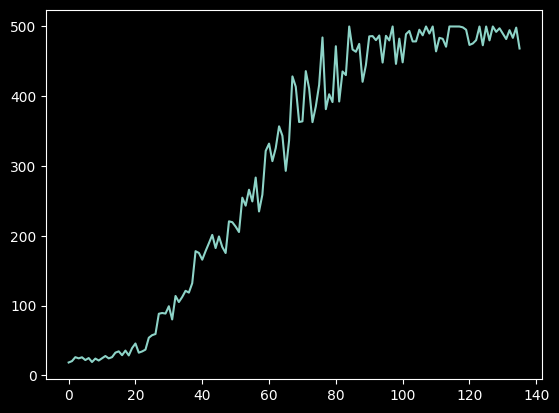

In [ ]:
if not len(all_returns)%configs.num_episodes_to_average==0:
    all_returns_truncated = np.array(all_returns[:-(len(all_returns)%configs.num_episodes_to_average)])
else:
    all_returns_truncated = all_returns
all_returns_smoothed = np.average(all_returns_truncated.reshape(-1, configs.num_episodes_to_average), axis=1)
print('mean reward:', np.mean(all_returns_smoothed))
print('std reward:', np.std(all_returns_smoothed))
print('max reward:', np.max(all_returns_smoothed))
print('converge mean reward:', np.mean(all_returns_smoothed[-1]))
plt.plot(all_returns_smoothed);

## Inference

In [ ]:
# create a test env
test_env = make_env_func(configs.gym_id, seed, 0, 'inference', True)()

# use the trained agent to run through the env till it terminates this is an eposide
observation, _ = test_env.reset()
observation = torch.unsqueeze(torch.tensor(observation),dim=0).to(device)
for _ in range(500):
    action, _, _, _ = agent.policy(observation)
    action = action.cpu().item()
    observation, reward, done, _, info = test_env.step(action)
    observation = torch.unsqueeze(torch.tensor(observation),dim=0).to(device)
    if done:
        break
test_env.close()

Moviepy - Building video /content/videos/inference/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/inference/rl-video-episode-0.mp4




t:  99%|█████████▊| 494/501 [00:02<00:00, 222.12it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/inference/rl-video-episode-0.mp4


In [ ]:
Video('/content/videos/inference/rl-video-episode-0.mp4', embed=True)

### BreakOut

You can use similar PPO setup to solve much more complex problems. The problem `"gym_id": "BreakoutNoFrameskip-v4"` is left as an exercise for you. The `env` and `agent` definitions are provided here but the rest are left to you. With the correct setup (very similar to what we did in CartPole), you should be able to get to respectable scores above 700. Even perfect score is possible with a tuned hyper-parameters with the same setup. Note that this is a much more complex problem and you will need to increase the `total_timesteps` by at least a factor of 30 to get to good results. This will take several hours.

```python
# extra imports
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)


# env definition
def make_env_func(gym_id, seed, idx, run_name, capture_video=False):
    def env_fun():
        env = gym.make(gym_id, render_mode='rgb_array')
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            # initiate the video capture if not already initiated
            if idx == 0:
                # wrapper to create the video of the performance
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return env_fun


# Model defnition
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):
    def __init__(self, envs):
        super(Agent, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.AdaptiveMaxPool2d(output_size=(1, 1)),
            nn.Flatten(),
            layer_init(nn.Linear(64, 512)),
            nn.ReLU(),
        )
        self.value_head = layer_init(nn.Linear(512, 1), std=1)
        self.policy_head = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)

    def value_func(self, x):
        return self.value_head(self.network(x / 255.0))

    def policy(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.policy_head(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.value_head(hidden)
```